In [4]:
from IPython.display import FileLink
!jupyter nbconvert --to notebook --output /kaggle/working/my_notebook.ipynb "$(basename "$_")" || echo "Notebook saved manually"


[NbConvertApp] WARNING | pattern '' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the note


# Stock Portfolio Performance

## Dataset Information

There are three disadvantages of weighted scoring stock selection models. First, they cannot identify the relations between weights of stock-picking concepts and performances of portfolios. Second, they cannot systematically discover the optimal combination for weights of concepts to optimize the performances. Third, they are unable to meet various investors' preferences. This study aims to more efficiently construct weighted scoring stock selection models to overcome these disadvantages. Since the weights of stock-picking concepts in a weighted scoring stock selection model can be regarded as components in a mixture, we used the simplex centroid mixture design to obtain the experimental sets of weights. These sets of weights are simulated with US stock market historical data to obtain their performances. Performance prediction models were built with the simulated performance data set and artificial neural networks. Furthermore, the optimization models to reflect investors' preferences were built up, and the performance prediction models were employed as the kernel of the optimization models so that the optimal solutions can now be solved with optimization techniques. The empirical values of the performances of the optimal weighting combinations generated by the optimization models showed that they can meet various investors' preferences and outperform those of S&P's 500 not only during the training period but also during the testing period.

In [201]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
stock_portfolio_performance = fetch_ucirepo(id=390) 
  
# data (as pandas dataframes) 
X = stock_portfolio_performance.data.features 
y = stock_portfolio_performance.data.targets 
  
# metadata 
#print(stock_portfolio_performance.metadata) 
  
# variable information 
print(stock_portfolio_performance.variables) 


                                     name     role         type demographic  \
0                                  period       ID  Categorical        None   
1                                      ID       ID      Integer        None   
2                               Large B/P  Feature   Continuous        None   
3                               Large ROE  Feature   Continuous        None   
4                               Large S/P  Feature   Continuous        None   
5   Large Return Rate in the last quarter  Feature   Continuous        None   
6                      Large Market Value  Feature   Continuous        None   
7                   Small systematic Risk  Feature   Continuous        None   
8                           Annual Return  Feature  Categorical        None   
9                           Excess Return  Feature  Categorical        None   
10                        Systematic Risk  Feature   Continuous        None   
11                             Total Risk  Feature  

| Variable Name | Role | Type | Description | Units | Missing Values |
|--------------|------|------|-------------|-------|----------------|
| period | ID | Categorical | Time period identifier | | no |
| ID | ID | Integer | Unique identifier for each record | | no |
| Large B/P | Feature | Continuous | Book-to-Price ratio for large cap stocks | | no |
| Large ROE | Feature | Continuous | Return on Equity for large cap stocks | | no |
| Large S/P | Feature | Continuous | Sales-to-Price ratio for large cap stocks | | no |
| Large Return Rate in the last quarter | Feature | Continuous | Quarterly return rate for large cap stocks | | no |
| Large Market Value | Feature | Continuous | Market capitalization of large cap stocks | | no |
| Small systematic Risk | Feature | Continuous | Systematic risk measure for small cap stocks | | no |
| Annual Return | Feature | Categorical | Annual return category (historical) | | no |
| Excess Return | Feature | Categorical | Excess return category (historical) | | no |
| Systematic Risk | Feature | Continuous | Market-related risk measure (historical) | | no |
| Total Risk | Feature | Categorical | Total risk category (historical) | | no |
| Abs. Win Rate | Feature | Categorical | Absolute win rate category (historical) | | no |
| Rel. Win Rate | Feature | Categorical | Relative win rate category (historical) | | no |
| Annual Return | Target | Continuous | Predicted annual return rate | | no |
| Excess Return | Target | Continuous | Predicted excess return over benchmark | | no |
| Systematic Risk | Target | Continuous | Predicted systematic/market risk | | no |
| Total Risk | Target | Continuous | Predicted total risk measure | | no |
| Abs. Win Rate | Target | Continuous | Predicted absolute win rate | | no |
| Rel. Win Rate | Target | Continuous | Predicted relative win rate | | no |

## Calculate some basic statistics of each column. Observe the value range of each feature.

In [202]:
X.describe()

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk,Systematic Risk
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,0.166619,0.166619,0.166619,0.166619,0.166619,0.166619,1.076514
std,0.198031,0.198031,0.198031,0.198031,0.198031,0.198031,0.196189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680929
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.943116
50%,0.167000,0.167000,0.167000,0.167000,0.167000,0.167000,1.040006
75%,0.333000,0.333000,0.333000,0.333000,0.333000,0.333000,1.170000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.939118


**Note** This dataset has multiple target variables (6 continuous targets), which means it's a multi-output regression problem.

## Target Selection

Annual Return was selected as the target variable as it represents the fundamental metric investors use to evaluate performance. Accurately predicting annual returns has direct practical applications in portfolio management and investment strategy.

### What to do with the other targets
The other target variables (Excess Return, Systematic Risk, Total Risk, Abs. Win Rate, Rel. Win Rate) are to be excluded from the feature set to prevent data leakage, as these represent future values that would not be available at prediction time.


In [203]:
# Define targets to drop
targets_to_drop = ['Excess Return', 'Systematic Risk', 'Total Risk', 
                   'Abs. Win Rate', 'Rel. Win Rate']

# Drop unwanted targets, keeping only Annual Return
y = y.drop(columns=targets_to_drop)

# Convert to Series and remove the % and store as float
y = y['Annual Return'].str.rstrip('%').astype(float)

y.head()

0    13.9
1    14.3
2    17.3
3     9.6
4     9.6
Name: Annual Return, dtype: float64

## Distributions of Target [Annual Return]

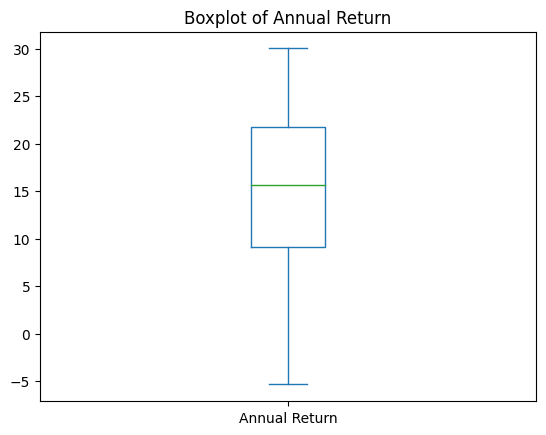

In [204]:
import matplotlib.pyplot as plt

# Assuming y is your Series
y.plot(kind='box')
plt.title("Boxplot of Annual Return")
plt.show()

## Normalisation of features

### Dropping the results features

I am removing the following features from the dataset as they represent future/result metrics that would not be available at the time of prediction:

- Annual Return (feature version)
- Excess Return (feature version)
- Systematic Risk (feature version)
- Total Risk (feature version)
- Abs. Win Rate (feature version)
- Rel. Win Rate (feature version)

In [205]:
# Features to drop (result-based metrics that cause data leakage)
result_features_to_drop = [
    'Annual Return',      # Result metric (feature version)
    'Excess Return',      # Result metric
    'Systematic Risk',    # Result metric
    'Total Risk',         # Result metric
    'Abs. Win Rate',      # Result metric
    'Rel. Win Rate'       # Result metric
]

# Drop from features
X = X.drop(columns=[col for col in result_features_to_drop if col in X.columns])

### Visualising feature distributions

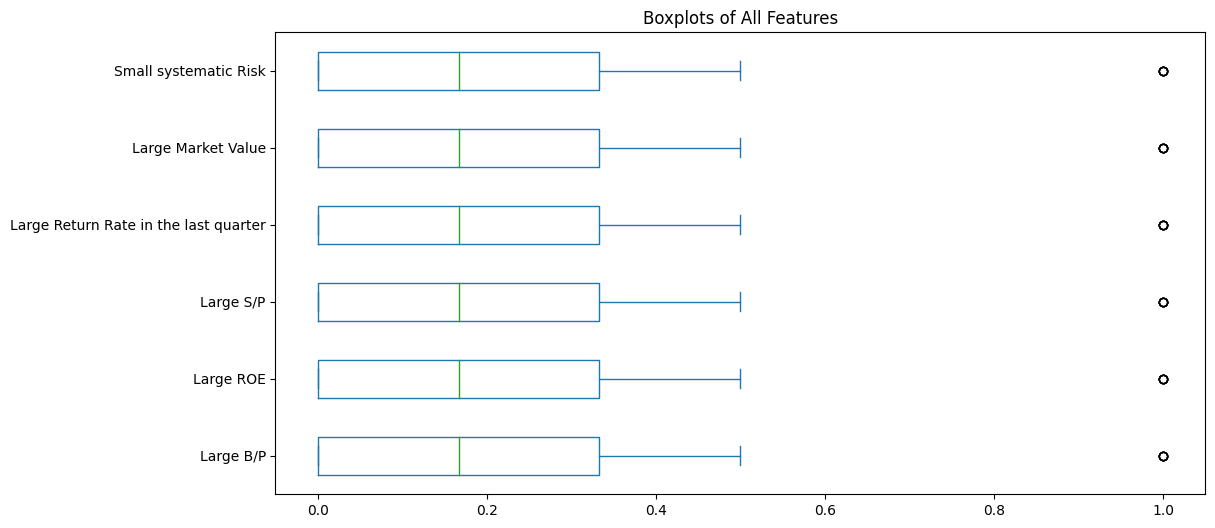

In [206]:
# Boxplot for all features
X.plot(kind='box', figsize=(12,6), vert=False)  # vert=False makes it horizontal
plt.title("Boxplots of All Features")
plt.show()

#### Analysis of features

After looking at the box plot, further analysis was considered. The feature matrix uses a systematic equal-weighting scheme to generate all possible factor combinations, progressing from single-factor portfolios (weight = 1.0) through increasingly diversified strategies (0.5, 0.33, 0.25, 0.20, 0.167). This design eliminates subjective weighting biases and creates an exhaustive 63-portfolio search space, allowing unbiased comparison between concentrated factor bets and diversified multi-factor approaches to determine which strategy yields superior risk-adjusted returns.

### Z-score Normalization

StandardScaler (z-score normalization) was applied to all features to standardize them to zero mean and unit variance. This approach is to be chosen because our data contains negative values (returns and ratios) and meaningful outliers that should be preserved. StandardScaler is also appropriate for linear models as it maintains the Gaussian distribution of features.

In [207]:
from sklearn.preprocessing import StandardScaler

# Best for your dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, 
                        columns=X_clean.columns,
                        index=X_clean.index)

X_scaled.head()

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk
0,4.215035,-0.842718,-0.842718,-0.842718,-0.842718,-0.842718
1,-0.842718,4.215035,-0.842718,-0.842718,-0.842718,-0.842718
2,-0.842718,-0.842718,4.215035,-0.842718,-0.842718,-0.842718
3,-0.842718,-0.842718,-0.842718,4.215035,-0.842718,-0.842718
4,-0.842718,-0.842718,-0.842718,-0.842718,4.215035,-0.842718


# Linear Regression

In [208]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Hyperparameters (Linear Regression has minimal hyperparameters)
LR_PARAMS = {
    'fit_intercept': True,
    'copy_X': True
}

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42
)

kf = KFold(n_splits=8, shuffle=True, random_state=42)

lr_val_mse_scores = []  # Changed from val_mse_scores
lr_val_r2_scores = []   # Changed from val_r2_scores

print("=" * 60)
print("LINEAR REGRESSION (BASELINE)")
print("=" * 60)
print(f"Hyperparameters: {LR_PARAMS}")
print("-" * 60)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp), 1):
    X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
    y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]
    
    # Train model
    model = LinearRegression(**LR_PARAMS)
    model.fit(X_train, y_train)
    
    # Predict and calculate metrics
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = model.score(X_val, y_val)
    
    lr_val_mse_scores.append(mse)  # Changed
    lr_val_r2_scores.append(r2)    # Changed
    print(f"Fold {fold} - MSE: {mse:.6f}, R²: {r2:.4f}")

print("-" * 60)
print(f"Average MSE: {np.mean(lr_val_mse_scores):.6f} (+/- {np.std(lr_val_mse_scores):.6f})")
print(f"Average R²: {np.mean(lr_val_r2_scores):.4f} (+/- {np.std(lr_val_r2_scores):.4f})")

# Final test
final_model = LinearRegression(**LR_PARAMS)
final_model.fit(X_temp, y_temp)
y_test_pred = final_model.predict(X_test)
lr_test_mse = mean_squared_error(y_test, y_test_pred)  # Changed from test_mse
lr_test_r2 = final_model.score(X_test, y_test)          # Changed from test_r2

print(f"Final Test MSE: {lr_test_mse:.6f}")
print(f"Final Test R²: {lr_test_r2:.4f}")
print("=" * 60)

LINEAR REGRESSION (BASELINE)
Hyperparameters: {'fit_intercept': True, 'copy_X': True}
------------------------------------------------------------
Fold 1 - MSE: 54.220792, R²: 0.0767
Fold 2 - MSE: 60.617920, R²: -0.0612
Fold 3 - MSE: 58.153785, R²: -0.1317
Fold 4 - MSE: 55.440604, R²: -0.1217
Fold 5 - MSE: 77.442150, R²: 0.0476
Fold 6 - MSE: 74.215125, R²: 0.0523
Fold 7 - MSE: 44.675355, R²: 0.0721
Fold 8 - MSE: 72.051856, R²: 0.0548
------------------------------------------------------------
Average MSE: 62.102199 (+/- 10.659586)
Average R²: -0.0014 (+/- 0.0829)
Final Test MSE: 51.471866
Final Test R²: 0.0864


# SVM

In [209]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Hyperparameters
SVM_PARAMS = {
    'kernel': 'rbf',
    'C': 1.0,
    'gamma': 'scale',
    'epsilon': 0.1
}

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

scaler = StandardScaler()
kf = KFold(n_splits=8, shuffle=True, random_state=42)

svm_val_mse_scores = []  # Changed
svm_val_r2_scores = []   # Changed

print("=" * 60)
print("SUPPORT VECTOR MACHINE (SVM)")
print("=" * 60)
print(f"Hyperparameters: {SVM_PARAMS}")
print("-" * 60)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp), 1):
    X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
    y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train model
    model = SVR(**SVM_PARAMS)
    model.fit(X_train_scaled, y_train)
    
    # Predict and calculate metrics
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    r2 = model.score(X_val_scaled, y_val)
    
    svm_val_mse_scores.append(mse)  # Changed
    svm_val_r2_scores.append(r2)    # Changed
    print(f"Fold {fold} - MSE: {mse:.6f}, R²: {r2:.4f}")

print("-" * 60)
print(f"Average MSE: {np.mean(svm_val_mse_scores):.6f} (+/- {np.std(svm_val_mse_scores):.6f})")
print(f"Average R²: {np.mean(svm_val_r2_scores):.4f} (+/- {np.std(svm_val_r2_scores):.4f})")

# Final test
scaler_final = StandardScaler()
X_temp_scaled = scaler_final.fit_transform(X_temp)
X_test_scaled = scaler_final.transform(X_test)

final_model = SVR(**SVM_PARAMS)
final_model.fit(X_temp_scaled, y_temp)
y_test_pred = final_model.predict(X_test_scaled)
svm_test_mse = mean_squared_error(y_test, y_test_pred)  # Changed
svm_test_r2 = final_model.score(X_test_scaled, y_test)  # Changed

print(f"Final Test MSE: {svm_test_mse:.6f}")
print(f"Final Test R²: {svm_test_r2:.4f}")
print("=" * 60)

SUPPORT VECTOR MACHINE (SVM)
Hyperparameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}
------------------------------------------------------------
Fold 1 - MSE: 56.074002, R²: 0.0451
Fold 2 - MSE: 54.818841, R²: 0.0403
Fold 3 - MSE: 47.950774, R²: 0.0668
Fold 4 - MSE: 57.038395, R²: -0.1540
Fold 5 - MSE: 81.480743, R²: -0.0021
Fold 6 - MSE: 76.024367, R²: 0.0292
Fold 7 - MSE: 48.004442, R²: 0.0029
Fold 8 - MSE: 73.391825, R²: 0.0372
------------------------------------------------------------
Average MSE: 61.847923 (+/- 12.300057)
Average R²: 0.0082 (+/- 0.0648)
Final Test MSE: 54.388807
Final Test R²: 0.0346


# Decision Tree

In [210]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Hyperparameters
DT_PARAMS = {
    'max_depth': 10,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'random_state': 42
}

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

kf = KFold(n_splits=8, shuffle=True, random_state=42)

dt_val_mse_scores = []  # Changed
dt_val_r2_scores = []   # Changed

print("=" * 60)
print("DECISION TREE")
print("=" * 60)
print(f"Hyperparameters: {DT_PARAMS}")
print("-" * 60)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp), 1):
    X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
    y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]
    
    # Train model
    model = DecisionTreeRegressor(**DT_PARAMS)
    model.fit(X_train, y_train)
    
    # Predict and calculate metrics
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = model.score(X_val, y_val)
    
    dt_val_mse_scores.append(mse)  # Changed
    dt_val_r2_scores.append(r2)    # Changed
    print(f"Fold {fold} - MSE: {mse:.6f}, R²: {r2:.4f}")

print("-" * 60)
print(f"Average MSE: {np.mean(dt_val_mse_scores):.6f} (+/- {np.std(dt_val_mse_scores):.6f})")
print(f"Average R²: {np.mean(dt_val_r2_scores):.4f} (+/- {np.std(dt_val_r2_scores):.4f})")

# Final test
final_model = DecisionTreeRegressor(**DT_PARAMS)
final_model.fit(X_temp, y_temp)
y_test_pred = final_model.predict(X_test)
dt_test_mse = mean_squared_error(y_test, y_test_pred)  # Changed
dt_test_r2 = final_model.score(X_test, y_test)         # Changed

print(f"Final Test MSE: {dt_test_mse:.6f}")
print(f"Final Test R²: {dt_test_r2:.4f}")
print("=" * 60)

DECISION TREE
Hyperparameters: {'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 10, 'random_state': 42}
------------------------------------------------------------
Fold 1 - MSE: 68.701120, R²: -0.1699
Fold 2 - MSE: 80.464780, R²: -0.4086
Fold 3 - MSE: 51.626472, R²: -0.0047
Fold 4 - MSE: 72.239203, R²: -0.4615
Fold 5 - MSE: 88.041819, R²: -0.0828
Fold 6 - MSE: 81.989521, R²: -0.0470
Fold 7 - MSE: 55.829582, R²: -0.1596
Fold 8 - MSE: 74.291802, R²: 0.0254
------------------------------------------------------------
Average MSE: 71.648037 (+/- 11.835049)
Average R²: -0.1636 (+/- 0.1695)
Final Test MSE: 68.550377
Final Test R²: -0.2168


# Multi Layered Perceptron Neural Network

In [211]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Hyperparameters
MLP_PARAMS = {
    'hidden_layer_sizes': (100, 50),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.0001,
    'batch_size': 'auto',
    'learning_rate': 'constant',
    'learning_rate_init': 0.001,
    'max_iter': 500,
    'random_state': 42,
    'early_stopping': True,
    'validation_fraction': 0.1
}

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

scaler = StandardScaler()
kf = KFold(n_splits=8, shuffle=True, random_state=42)

mlp_val_mse_scores = []  # Changed
mlp_val_r2_scores = []   # Changed

print("=" * 60)
print("MULTILAYER PERCEPTRON (MLP)")
print("=" * 60)
print(f"Hyperparameters: {MLP_PARAMS}")
print("-" * 60)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp), 1):
    X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
    y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train model
    model = MLPRegressor(**MLP_PARAMS)
    model.fit(X_train_scaled, y_train)
    
    # Predict and calculate metrics
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    r2 = model.score(X_val_scaled, y_val)
    
    mlp_val_mse_scores.append(mse)  # Changed
    mlp_val_r2_scores.append(r2)    # Changed
    print(f"Fold {fold} - MSE: {mse:.6f}, R²: {r2:.4f}")

print("-" * 60)
print(f"Average MSE: {np.mean(mlp_val_mse_scores):.6f} (+/- {np.std(mlp_val_mse_scores):.6f})")
print(f"Average R²: {np.mean(mlp_val_r2_scores):.4f} (+/- {np.std(mlp_val_r2_scores):.4f})")

# Final test
scaler_final = StandardScaler()
X_temp_scaled = scaler_final.fit_transform(X_temp)
X_test_scaled = scaler_final.transform(X_test)

final_model = MLPRegressor(**MLP_PARAMS)
final_model.fit(X_temp_scaled, y_temp)
y_test_pred = final_model.predict(X_test_scaled)
mlp_test_mse = mean_squared_error(y_test, y_test_pred)  # Changed
mlp_test_r2 = final_model.score(X_test_scaled, y_test)  # Changed

print(f"Final Test MSE: {mlp_test_mse:.6f}")
print(f"Final Test R²: {mlp_test_r2:.4f}")
print("=" * 60)

MULTILAYER PERCEPTRON (MLP)
Hyperparameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'batch_size': 'auto', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 500, 'random_state': 42, 'early_stopping': True, 'validation_fraction': 0.1}
------------------------------------------------------------
Fold 1 - MSE: 55.870698, R²: 0.0486
Fold 2 - MSE: 59.623302, R²: -0.0438
Fold 3 - MSE: 62.316118, R²: -0.2127
Fold 4 - MSE: 101.409180, R²: -1.0517
Fold 5 - MSE: 85.465004, R²: -0.0511
Fold 6 - MSE: 80.601215, R²: -0.0293
Fold 7 - MSE: 103.040175, R²: -1.1402
Fold 8 - MSE: 86.174892, R²: -0.1305
------------------------------------------------------------
Average MSE: 79.312573 (+/- 17.189866)
Average R²: -0.3263 (+/- 0.4506)
Final Test MSE: 56.790804
Final Test R²: -0.0080


# Summary

In [212]:
# Create summary table
import pandas as pd

summary = pd.DataFrame({
    'Model': ['Linear Regression', 'SVM', 'Decision Tree', 'MLP'],
    'Avg MSE': [
        np.mean(lr_val_mse_scores),
        np.mean(svm_val_mse_scores),
        np.mean(dt_val_mse_scores),
        np.mean(mlp_val_mse_scores)
    ],
    'Std MSE': [
        np.std(lr_val_mse_scores),
        np.std(svm_val_mse_scores),
        np.std(dt_val_mse_scores),
        np.std(mlp_val_mse_scores)
    ],
    'Test MSE': [lr_test_mse, svm_test_mse, dt_test_mse, mlp_test_mse]
})

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(summary.to_string(index=False))
print("=" * 80)


MODEL COMPARISON SUMMARY
            Model   Avg MSE   Std MSE  Test MSE
Linear Regression 62.102199 10.659586 51.471866
              SVM 61.847923 12.300057 54.388807
    Decision Tree 71.648037 11.835049 68.550377
              MLP 79.312573 17.189866 56.790804
